## Import the required libraries and initialize H2OContext

In [2]:
from pysparkling import *
import h2o
import seaborn as sns
%matplotlib inline


In [3]:
hc = H2OContext(sc).start()


H2O cluster uptime:,4 seconds 800 milliseconds
H2O cluster version:,3.8.2.3
H2O cluster name:,sparkling-water-ubuntu_-1422497723
H2O cluster total nodes:,1
H2O cluster total free memory:,982.0 MB
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster healthy:,True
H2O Connection ip:,127.0.0.1
H2O Connection port:,54327
H2O Connection proxy:,None


## H2O Context info

In [4]:
hc

H2OContext: ip=127.0.0.1, port=54327 (open UI at http://127.0.0.1:54327 )


## Import data into H2O

In [5]:
attrition = h2o.import_file(path ="../data/attrition.csv",
                            col_types = (["numeric"]*8 + ["enum"]), 
                            destination_frame= "attrition")


Parse Progress: [##################################################] 100%


In [6]:
print(attrition.shape)
attrition.summary()

(160, 9)


,CustID,Gender,Age,Income,FamilySize,Education,Calls,Visits,Churn
type,int,int,int,int,int,int,int,int,enum
mins,101901.0,0.0,17.0,0.0,1.0,12.0,3.0,0.0,0.0
mean,151143.5,0.58125,35.66875,0.50625,3.13125,14.9625,25.21875,1.90625,0.53125
maxs,199131.0,1.0,82.0,1.0,5.0,20.0,65.0,5.0,1.0
sigma,28408.9141624,0.494903268612,16.3359856177,0.501530675899,1.04081411652,2.60113062016,13.3098875031,1.46573816379,0.500589275396
zeros,0,67,0,79,0,0,0,31,75
missing,0,0,0,0,0,0,0,0,0
0,101901.0,1.0,30.0,0.0,5.0,20.0,37.0,3.0,1
1,102056.0,0.0,17.0,1.0,1.0,12.0,25.0,1.0,0
2,102522.0,1.0,54.0,1.0,4.0,18.0,48.0,3.0,1


## Data munging in Spark

In [7]:
spark_df_attrition = hc.as_spark_frame(attrition)

In [8]:
spark_df_attrition.show(5)

+------+------+---+------+----------+---------+-----+------+-----+
|CustID|Gender|Age|Income|FamilySize|Education|Calls|Visits|Churn|
+------+------+---+------+----------+---------+-----+------+-----+
|101901|     1| 30|     0|         5|       20|   37|     3|    1|
|102056|     0| 17|     1|         1|       12|   25|     1|    0|
|102522|     1| 54|     1|         4|       18|   48|     3|    1|
|103149|     1| 42|     1|         2|       17|   51|     2|    1|
|103866|     0| 30|     1|         2|       12|   26|     1|    0|
+------+------+---+------+----------+---------+-----+------+-----+
only showing top 5 rows



In [9]:
sqlContext.registerDataFrameAsTable(spark_df_attrition, "spark_df_attrition")

In [10]:
adults = sqlContext.sql("SELECT * FROM spark_df_attrition where Age > 18") # 18+ ;)

In [11]:
adults.show(5)

+------+------+---+------+----------+---------+-----+------+-----+
|CustID|Gender|Age|Income|FamilySize|Education|Calls|Visits|Churn|
+------+------+---+------+----------+---------+-----+------+-----+
|101901|     1| 30|     0|         5|       20|   37|     3|    1|
|102522|     1| 54|     1|         4|       18|   48|     3|    1|
|103149|     1| 42|     1|         2|       17|   51|     2|    1|
|103866|     0| 30|     1|         2|       12|   26|     1|    0|
|103976|     0| 23|     0|         4|       16|   18|     0|    0|
+------+------+---+------+----------+---------+-----+------+-----+
only showing top 5 rows



## Continue in H2O

In [12]:
adults_hf = hc.as_h2o_frame(adults,framename="adults")

In [13]:
adults_hf["Churn"]= adults_hf["Churn"].asfactor()

In [14]:
# Split final H2O data table into train and validatoin
ratios = [0.7] # [0.6,0.2] 
frs = adults_hf.split_frame(ratios,seed=12345)
train = frs[0]
train.frame_id = "Train"
valid = frs[1]
valid.frame_id = "Valid"

In [15]:
# Import Model Builders from H2O Python
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [16]:
# Define Preditors
predictors = adults_hf.names[:]
response = "Churn"
predictors.remove(response)
predictors.remove("CustID")

In [17]:
#Simple GBM model - Predict Arrest
model_gbm = H2OGradientBoostingEstimator(ntrees        = 50,
                                        max_depth      = 6,
                                        learn_rate     = 0.1, 
                                        #nfolds         = 2,
                                        distribution   = "bernoulli")

model_gbm.train(x               = predictors,
               y                = response,
               training_frame   = train,
               validation_frame = valid
               )



gbm Model Build Progress: [##################################################] 100%


In [19]:

# Print confusion matrices for the train and validation set
print(model_gbm.confusion_matrix(train = True))
print(model_gbm.confusion_matrix(valid = True))


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.504441574728: 


,0,1,Error,Rate
0,45.0,0.0,0.0,(0.0/45.0)
1,0.0,55.0,0.0,(0.0/55.0)
Total,45.0,55.0,0.0,(0.0/100.0)




Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.504463466656: 


,0,1,Error,Rate
0,18.0,6.0,0.25,(6.0/24.0)
1,4.0,14.0,0.2222,(4.0/18.0)
Total,22.0,20.0,0.2381,(10.0/42.0)


1.0
0.81712962963


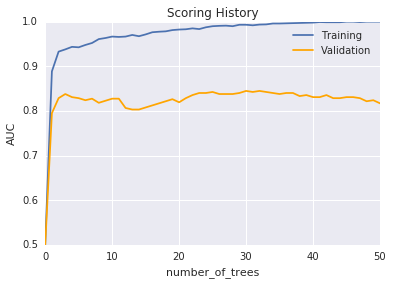

In [20]:

print(model_gbm.auc(train=True))
print(model_gbm.auc(valid=True))
model_gbm.plot(metric="AUC")

0.0349021544174
0.177750518056


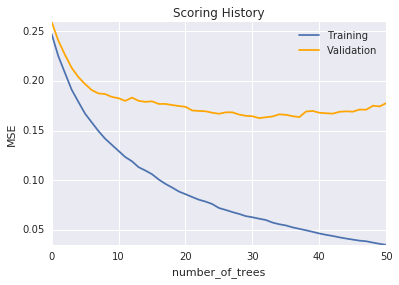

In [22]:
print(model_gbm.mse(train=True))
print(model_gbm.mse(valid=True))
model_gbm.plot(metric="MSE")